<a id="top"></a>
## NIRISS AMI simulation of binary point source AB-Dor and calibrator HD37093


***

## Imports
Describe the libraries we're using here. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *matplotlib.pyplot* for plotting data
- *zipfile* for accessing zip file
- *urllib.request* to access URL
- *yaml* to create yaml files
- *mirage* to simulate JWST data
- *IPython.display Image* to display png file

In [1]:
%matplotlib inline

import glob
import io
import os
import sys

from astropy.io import fits
import matplotlib.pyplot as plt
import yaml
import zipfile
import urllib.request
from IPython.display import Image

from mirage import imaging_simulator
from mirage.yaml import yaml_generator

In order to produce data that is as realistic as possible, Mirage is accompanied by a set of reference files that are used to construct the simulated data.

*Developer Note:*
If you are outside STScI install the mirage data by following instructions on https://mirage-data-simulator.readthedocs.io/en/latest/reference_files.html and create MIRAGE_DATA location.

In [2]:
if os.environ.get('MIRAGE_DATA', None) is None:
    os.environ['MIRAGE_DATA'] = '/path/to/mirage_data/'

# Introduction
*Developer Note:*
Activate your mirage environment and type 'jupyter notebook at the prompt

This notebook creates MIRAGE simulations for binary point source AB-Dor and calibrator HD37093 using the Aperture Masking Interferometry (AMI) mode on JWST NIRISS. The sources are observed with the Non-redundant mask (NRM) in the pupil wheel and filter F480M in the filter wheel at POS1 dither position near the center of SUB80 array.

The current analysis tools are work in progress and do not give correct results if the data has bad pixels. The simulations are therefore created using dark ramps without bad pixels.

### Description of reference files used for simulations

We are using the following non-default reference files to generate the simulation. 
- dark000001_uncal.fits has ngroups = 5 and is used for AB Dor observation that also has ngroups = 5. 
- dark000005_uncal.fits has ngroups = 12 and is used for HD37093 observation that also has ngroups = 12. 
- jwst_niriss_gain_general.fits is the gain file with one value for all pixels 
- jwst_niriss_flat_general.fits is the flat field reference file with no structure 
- jwst_niriss_superbias_sim.fits bias reference file to match the simulation

We are temporarily using local niriss_gridded_psf_library that was created using a new version of non redundant mask. When Mirage gridded psf library gets updated with WebbPSF PSFs that use new version of NRM we can switch back to the default library.



***

### Loading input files and reference files

In [3]:
boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/niriss_ami_binary/niriss_ami_binary1.zip'
boxfile = './niriss_ami_binary1.zip'

# Download zip file
if not os.path.exists(boxfile):
    urllib.request.urlretrieve(boxlink, boxfile)
    
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()

### Create output directory to store simulated data

In [4]:
odir = './mirage_sim_data'
if not os.path.exists(odir):
        os.mkdir(odir)
simdata_output_directory = odir

### Generating input yaml files

Start working on the simulation starting with the APT file. The xml and pointings files must be exported from APT by using 'File ---> Export' option in APT. These files are then used as input to the yaml_generator, that generates yaml input files for each exposure.

We are including the xml and pointing files along with other file included in the zip file.



In [5]:
#Write down the name of the APT file in comments for quick reference and also store it in the same folder as xml and 
#pointing files for easy access and to remember which APT file was used for simulations.
#APT file used niriss_ami_binary_2022.25coords.aptx 
xml_name = './mirage_input_files/niriss_ami_binary_2022.25coords.xml'
pointing_name = './mirage_input_files/niriss_ami_binary_2022.25coords.pointing'

We will generate NIRISS AMI simulations of a binary point source using the catalogue stars_field19_20_combined_allfilters_new.list. This catalogue contains the coordinates and magnitudes of AB-Dor, HD37093 along with several other faint sources in the field. 

(Need to highlight this)
NOTE: Mirage currently does not apply proper motion that is entered in the APT fie. It is therefore important to enter  coordinates at the epoch of observation in the APT file. AB-Dor is a high proper motion star so we are using 2022.25 coordinates in the APT file and input source list file.


The first line in this file is for AB-Dor primary star and the second line is the faint companion that we are trying to detect. Several lines below is the reference star or calibrator star HD37093.
```
# 
# vegamag
# 
# 
x_or_RA y_or_Dec niriss_f090w_magnitude niriss_f115w_magnitude niriss_f140m_magnitude niriss_f150w_magnitude niriss_f158m_magnitude niriss_f200w_magnitude niriss_f277w_magnitude niriss_f356w_magnitude niriss_f380m_magnitude niriss_f430m_magnitude niriss_f444w_magnitude niriss_f480m_magnitude
  82.18740518  -65.44767541   5.88850   5.49770   5.07560   4.95800   4.83650   4.72940   4.72220   4.61000   4.61000   4.61000   4.61000   4.61000
  82.18717120  -65.44764863  12.06621  10.73581  10.47740  10.15193   9.84442   9.76398   9.75940   8.99121   8.69367   8.76689   8.81310   8.81310
  82.18534722  -65.44612065   8.88930   8.38010   7.86780   7.70440   7.54010   7.38740   7.38650   7.29090   7.28470   7.33890   7.38820   7.49960
  82.19501500  -65.44532800  12.13360  12.89690  12.47030  12.40400  12.28660  13.19490  14.01950  14.60890  14.67080  15.09080  15.20730  15.56880
  82.19343600  -65.45299500  13.54130  13.63920  13.68400  13.69520  13.70530  13.74310  13.76640  13.78850  13.78900  13.79520  13.79330  13.79180
  
...more sources...

# 
# vegamag
# 
# 
#x_or_RA y_or_Dec niriss_f090w_magnitude niriss_f115w_magnitude niriss_f140m_magnitude niriss_f150w_magnitude niriss_f158m_magnitude niriss_f200w_magnitude niriss_f277w_magnitude niriss_f356w_magnitude niriss_f380m_magnitude niriss_f430m_magnitude niriss_f444w_magnitude niriss_f480m_magnitude
  	
  82.78450088  -65.12833088   7.33570   6.74320   6.18410   5.99130   5.80110   5.61850   5.62170   5.49700   5.49700   5.53100   5.53100   5.53100

```

In [6]:
catalogues = {'AB-DOR': {'point_source':  './mirage_input_files/stars_field19_20_combined_allfilters_new.list'
                        },
              'HD-37093': {'point_source': './mirage_input_files/stars_field19_20_combined_allfilters_new.list'
                        }
             }   

### Set the telescope roll angle PAV3 for each observation. Another way to get PAV3 is from the APT file Reports.

In [7]:
obs1 = 1
pav3_obs1 = yaml_generator.default_obs_v3pa_on_date(pointing_name, obs1, date='2022-04-01')
obs2 = 2
pav3_obs2 = yaml_generator.default_obs_v3pa_on_date(pointing_name, obs2, date='2022-04-01')

roll_angle = {'001':pav3_obs1 , '002': pav3_obs2}

dates = '2022-04-01'
reffile_defaults = 'crds'
datatype = 'raw'

### Run the yaml generator 

This will create two yaml files that will be used as an input when creating the simulated data. There will be one yaml file for exposure in an observation. In our case we have one F480M exposure in each observation.

In [8]:
#Delete yaml files from previous run
#yaml_list = glob.glob(os.path.join(odir, 'jw*yaml'))
#for yaml in yaml_list:
#    os.remove(yaml)
    
yam = yaml_generator.SimInput(input_xml = xml_name, pointing_file = pointing_name,
                              catalogs = catalogues, roll_angle = roll_angle,
                              dates = dates, reffile_defaults = reffile_defaults,
                              verbose = True, output_dir = odir,
                              simdata_output_dir = simdata_output_directory,
                              datatype = datatype)

yam.create_inputs()
print("Created yaml files")

#Create yaml files for all observations.
yaml_files = sorted(glob.glob(os.path.join(odir, 'jw*.yaml')))

print(yaml_files)

CRDS_PATH environment variable not set. Setting to /Users/thatte/crds_cache
target_info:
{'AB-DOR': ('05:28:44.9772', '-65:26:51.63'), 'HD-37093': ('05:31:8.2802', '-65:07:41.99')}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `None` uses template `NirissAmi`
APTObservationParams Dictionary holds 0 entries before reading template
Number of dithers: 1 primary * 1 subpixel = 1
Dictionary read from template has 1 entries.
Found 0.0 tile(s) for observation 001 Observation 1
Found 1 visits with numbers: [1]
APTObservationParams Dictionary holds 1 entries after reading template (+1 entries)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `002` labelled `None` uses template `NirissAmi`
APTObservationParams Dictionary holds 1 entries before reading template
Number of dithers: 1 primary * 1 subpixel = 1
Dictionary read from template has 1 entries.
Fo

### Update the contents of yaml files and generate raw data

Updating the yaml files is not always required. We are doing it here to generate data without bad pixels and to make a few other modifications.

In [9]:
for file in yaml_files:
    
    # set astrometric reference file to None to use pysiaf
    # To create data without bad pixels use the following reference files.
    with open(file, 'r') as infile:
        yaml_content = yaml.safe_load(infile)
    yaml_content['Reffiles']['astrometric'] = 'None'
    yaml_content['simSignals']['psf_wing_threshold_file'] = 'config'
    yaml_content['Reffiles']['linearized_darkfile'] = 'None'
    yaml_content['simSignals']['psfpath'] = './ref_files_non_default/niriss_gridded_psf_library_newmask'
    yaml_content['Reffiles']['gain'] = './ref_files_non_default/jwst_niriss_gain_general.fits'
    yaml_content['Reffiles']['pixelflat'] = './ref_files_non_default/jwst_niriss_flat_general.fits'
    yaml_content['Reffiles']['superbias'] = './ref_files_non_default/jwst_niriss_superbias_sim.fits'

    
    if "jw01093001" in file:
       yaml_content['Reffiles']['dark'] = './ref_files_non_default/simdarks/dark000001/dark000001_uncal.fits'
    elif "jw01093002" in file:
       yaml_content['Reffiles']['dark'] = './ref_files_non_default/simdarks/dark000005/dark000005_uncal.fits'
    

    modified_file = file.replace('.yaml', '_mod.yaml')
    with io.open(modified_file, 'w') as outfile:
        yaml.dump(yaml_content, outfile, default_flow_style=False)


    print("Updated yaml files. The jw*_mod.yaml files will be used to create data")
    
    #create data
    t1 = imaging_simulator.ImgSim()
    t1.paramfile = str(modified_file)
    t1.create()

Updated yaml files. The jw*_mod.yaml files will be used to create data


Running catalog_seed_image..

From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
Found an existing inverted kernel for this IPC file: /Users/thatte/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_area_0011.fits as the pixelAreaMap reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_photom_0038.fits as the phot

2020-09-17 10:49:13,884 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'
2020-09-17 10:49:13,887 - stpipe.dq_init - INFO - DQInitStep instance created.
2020-09-17 10:49:13,976 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 2048, 2048) from dark000001_uncal.fits>,).
2020-09-17 10:49:13,978 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-09-17 10:49:13,993 - stpipe.dq_init - INFO - Using MASK reference file /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


Creating a linearized version of the dark current input ramp
using JWST calibration pipeline.


2020-09-17 10:49:14,505 - stpipe.dq_init - INFO - Step dq_init done
2020-09-17 10:49:14,583 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   Unknown reference type 'pars-saturationstep'
2020-09-17 10:49:14,593 - stpipe.saturation - INFO - SaturationStep instance created.
2020-09-17 10:49:14,662 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 2048, 2048) from dark000001_uncal.fits>,).
2020-09-17 10:49:14,665 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-09-17 10:49:14,681 - stpipe.saturation - INFO - Using SATURATION reference file /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits
2020-09-17 10:49:15,087 - stpipe.saturation 

Linearized dark shape: (1, 5, 2048, 2048)
Output is NISRAPID, grabbing zero frame from linearized dark
File number 0 will be used for integrations [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.


Segment 1 out of 1 complete.

Running observation generator....

From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/that

    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
Integration 48:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
Integration 49:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
Integration 50:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
Integration 51:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
Integration 52:
    Averaging frame 0 into group 0
    Averag

WCS info for /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits complete.
2020-09-17 10:49:25,886 - stpipe - INFO - WCS info for /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits complete.


Final raw exposure saved to: 
/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits


Segment 1 out of 1 complete.
Observation generation complete.
Updated yaml files. The jw*_mod.yaml files will be used to create data


Running catalog_seed_image..

From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
Found an existing inverted kernel for this IPC file: /Users/thatte/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits
From CRDS, fo

2020-09-17 10:49:34,473 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'
2020-09-17 10:49:34,477 - stpipe.dq_init - INFO - DQInitStep instance created.
2020-09-17 10:49:34,673 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 5, 2048, 2048) from dark000001_uncal.fits>,).


Creating a linearized version of the dark current input ramp
using JWST calibration pipeline.


2020-09-17 10:49:34,676 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-09-17 10:49:34,690 - stpipe.dq_init - INFO - Using MASK reference file /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits
2020-09-17 10:49:35,133 - stpipe.dq_init - INFO - Step dq_init done
2020-09-17 10:49:35,211 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   Unknown reference type 'pars-saturationstep'
2020-09-17 10:49:35,215 - stpipe.saturation - INFO - SaturationStep instance created.
2020-09-17 10:49:35,283 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 5, 2048, 2048) from dark000001_uncal.fits>,).
2020-09-17 10:49:35,286 - stpipe.saturation - INFO - Step saturat

Linearized dark shape: (1, 5, 2048, 2048)
Output is NISRAPID, grabbing zero frame from linearized dark
File number 0 will be used for integrations [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.


Segment 1 out of 1 complete.

Running observation generator....

From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/that

    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
Integration 52:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
Integration 53:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
Integration 54:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
Integration 55:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
Integration 56:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averag

WCS info for /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits complete.
2020-09-17 10:49:43,373 - stpipe - INFO - WCS info for /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits complete.


Final raw exposure saved to: 
/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits


Segment 1 out of 1 complete.
Observation generation complete.
Updated yaml files. The jw*_mod.yaml files will be used to create data


Running catalog_seed_image..

From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
Found an existing inverted kernel for this IPC file: /Users/thatte/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits
From CRDS, fo

2020-09-17 10:49:52,348 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'
2020-09-17 10:49:52,351 - stpipe.dq_init - INFO - DQInitStep instance created.
2020-09-17 10:49:52,541 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 12, 2048, 2048) from dark000005_uncal.fits>,).
2020-09-17 10:49:52,543 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


Creating a linearized version of the dark current input ramp
using JWST calibration pipeline.


2020-09-17 10:49:52,554 - stpipe.dq_init - INFO - Using MASK reference file /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits
2020-09-17 10:49:53,124 - stpipe.dq_init - INFO - Step dq_init done
2020-09-17 10:49:53,187 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   Unknown reference type 'pars-saturationstep'
2020-09-17 10:49:53,196 - stpipe.saturation - INFO - SaturationStep instance created.
2020-09-17 10:49:53,265 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 12, 2048, 2048) from dark000005_uncal.fits>,).
2020-09-17 10:49:53,268 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-09-17 10:49:53,284 - stpipe.saturation - INFO - Using

Linearized dark shape: (1, 12, 2048, 2048)
Output is NISRAPID, grabbing zero frame from linearized dark
File number 0 will be used for integrations [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.


Segment 1 out of 1 complete.

Running observation generator....

From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/thatte/crds_cache/

    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
    Averaging frame 5 into group 5
    Averaging frame 6 into group 6
    Averaging frame 7 into group 7
    Averaging frame 8 into group 8
    Averaging frame 9 into group 9
    Averaging frame 10 into group 10
    Averaging frame 11 into group 11
Integration 24:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
    Averaging frame 5 into group 5
    Averaging frame 6 into group 6
    Averaging frame 7 into group 7
    Averaging frame 8 into group 8
    Averaging frame 9 into group 9
    Averaging frame 10 into group 10
    Averaging frame 11 into group 11
Integration 25:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging f

    Averaging frame 10 into group 10
    Averaging frame 11 into group 11
Integration 48:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
    Averaging frame 5 into group 5
    Averaging frame 6 into group 6
    Averaging frame 7 into group 7
    Averaging frame 8 into group 8
    Averaging frame 9 into group 9
    Averaging frame 10 into group 10
    Averaging frame 11 into group 11
Integration 49:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
    Averaging frame 5 into group 5
    Averaging frame 6 into group 6
    Averaging frame 7 into group 7
    Averaging frame 8 into group 8
    Averaging frame 9 into group 9
    Averaging frame 10 into group 10
    Averaging frame 11 into group 11
Integration 50:
    Averaging frame 0 into gro

WCS info for /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits complete.
2020-09-17 10:50:09,346 - stpipe - INFO - WCS info for /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits complete.


Final raw exposure saved to: 
/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits


Segment 1 out of 1 complete.
Observation generation complete.
Updated yaml files. The jw*_mod.yaml files will be used to create data


Running catalog_seed_image..

From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0010.fits as the saturation reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
Found an existing inverted kernel for this IPC file: /Users/thatte/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits
From CRDS, fo

2020-09-17 10:50:18,869 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'
2020-09-17 10:50:18,878 - stpipe.dq_init - INFO - DQInitStep instance created.
2020-09-17 10:50:19,142 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 12, 2048, 2048) from dark000005_uncal.fits>,).


Creating a linearized version of the dark current input ramp
using JWST calibration pipeline.


2020-09-17 10:50:19,144 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-09-17 10:50:19,158 - stpipe.dq_init - INFO - Using MASK reference file /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits
2020-09-17 10:50:19,763 - stpipe.dq_init - INFO - Step dq_init done
2020-09-17 10:50:19,825 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   Unknown reference type 'pars-saturationstep'
2020-09-17 10:50:19,834 - stpipe.saturation - INFO - SaturationStep instance created.
2020-09-17 10:50:19,906 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 12, 2048, 2048) from dark000005_uncal.fits>,).
2020-09-17 10:50:19,909 - stpipe.saturation - INFO - Step satura

Linearized dark shape: (1, 12, 2048, 2048)
Output is NISRAPID, grabbing zero frame from linearized dark
File number 0 will be used for integrations [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.


Segment 1 out of 1 complete.

Running observation generator....

From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
From CRDS, found /Users/thatte/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0011.fits as the linearity reference file.
From CRDS, found /Users/thatte/crds_cache/

    Averaging frame 6 into group 6
    Averaging frame 7 into group 7
    Averaging frame 8 into group 8
    Averaging frame 9 into group 9
    Averaging frame 10 into group 10
    Averaging frame 11 into group 11
Integration 25:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
    Averaging frame 5 into group 5
    Averaging frame 6 into group 6
    Averaging frame 7 into group 7
    Averaging frame 8 into group 8
    Averaging frame 9 into group 9
    Averaging frame 10 into group 10
    Averaging frame 11 into group 11
Integration 26:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
    Averaging frame 5 into group 5
    Averaging frame 6 into group 6
    Averaging frame 7 into group 7
    Averaging frame 8 into group 8
    Averaging f

    Averaging frame 8 into group 8
    Averaging frame 9 into group 9
    Averaging frame 10 into group 10
    Averaging frame 11 into group 11
Integration 50:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
    Averaging frame 5 into group 5
    Averaging frame 6 into group 6
    Averaging frame 7 into group 7
    Averaging frame 8 into group 8
    Averaging frame 9 into group 9
    Averaging frame 10 into group 10
    Averaging frame 11 into group 11
Integration 51:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
    Averaging frame 5 into group 5
    Averaging frame 6 into group 6
    Averaging frame 7 into group 7
    Averaging frame 8 into group 8
    Averaging frame 9 into group 9
    Averaging frame 10 into group 10
    Averaging

WCS info for /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits complete.
2020-09-17 10:50:36,025 - stpipe - INFO - WCS info for /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits complete.


Final raw exposure saved to: 
/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits


Segment 1 out of 1 complete.
Observation generation complete.


## Useful output products generated by Mirage

```
- jw01093001001_01101_00001_nis_uncal_pointsources.list and jw01093002001_01101_00001_nis_uncal_pointsources.
  list. The first line of jw01093001001_01101_00001_nis_uncal_pointsources.list shows coordinates of AB-Dor,
  the pixel coordinates at which the data is simulated, magnitude and total count rate.
   
- jw01093001001_01101_00001_nis_uncal_F480M_NRM_final_seed_image.fits and  
  jw01093002001_01101_00001_nis_uncal_F480M_NRM_final_seed_image.fits
  A seed image is a noiseless image that contains signal only from simulated astronomical sources. It can be 
  used for quality checks on the final output data.

- jw01093001001_01101_00001_nis_uncal.fits and jw01093002001_01101_00001_nis_uncal.fits
  AB-dor and HD37093 raw data
```

### Examine the seed images

In [10]:
data_seed=[]
seed_images = sorted(glob.glob('mirage_sim_data/jw*final_seed_image.fits'))
for i, df in enumerate(seed_images):
    seed_im = fits.open(df)
    seed_im.info()
    im = seed_im[1].data    
    print(im.shape)
    data_seed.append(im)
print(data_seed[0].shape, data_seed[1].shape)

f = plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("AB-Dor seed image")
plt.imshow(data_seed[0], origin='lower')
plt.subplot(1, 2, 2)
plt.title("HD37093 seed image")
plt.imshow(data_seed[1], origin='lower')

Filename: mirage_sim_data/jw01093001001_01101_00001_nis_uncal_F480M_NRM_final_seed_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  DATA          1 ImageHDU        61   (80, 80)   float64   
  2  SEGMAP        1 ImageHDU         8   (80, 80)   float64   
(80, 80)
Filename: mirage_sim_data/jw01093002001_01101_00001_nis_uncal_F480M_NRM_final_seed_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  DATA          1 ImageHDU        61   (80, 80)   float64   
  2  SEGMAP        1 ImageHDU         8   (80, 80)   float64   
(80, 80)
(80, 80) (80, 80)


### Compare peak pixel count rate for AB-Dor seed image with peak count rate in equivalent JWST ETC calculation

Pixel count rate for AB-Dor simulated image 44355.20895620601 ADU/s
Pixel count rate for AB-Dor simulated image 71411.88641949167 electrons/s


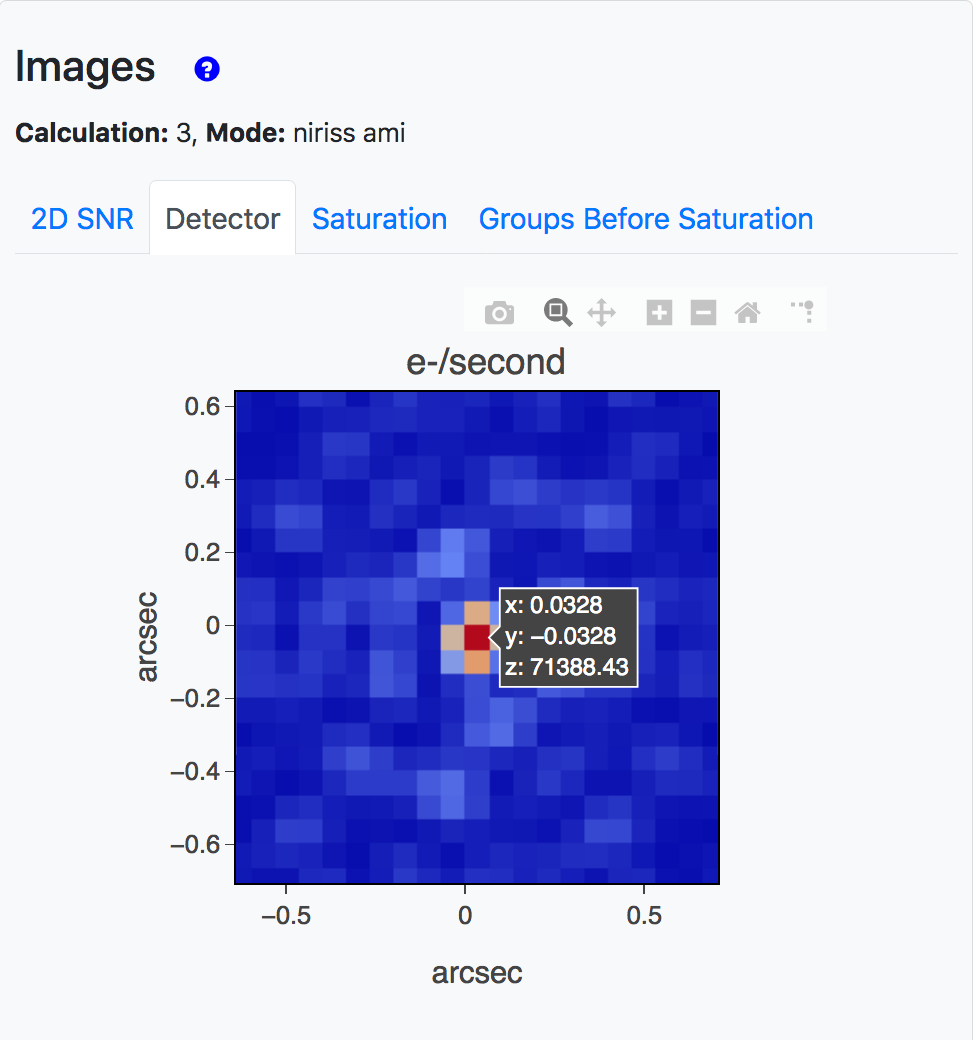

In [14]:
print("Pixel count rate for AB-Dor simulated image", data_seed[0].max(), "ADU/s")
print("Pixel count rate for AB-Dor simulated image", data_seed[0].max()*1.61, "electrons/s")
#Upload screenshot from the ETC workbook.
from IPython.display import Image
Image("AB_Dor_ngroup5_nint65_F480M_jwWTCcalc.png", width = 500, height = 500)

Comparison of the peak pixel count rate for AB-Dor simulated data with an equivalent JWST ETC calculation shows that the ETC peak pixel count rate of 71388.43 electrons/sec closely matches Mirage simulation. 

### Examine the raw data

In [12]:
datafiles = sorted(glob.glob('mirage_sim_data/jw*uncal.fits'))
m = glob.glob("*")
print(datafiles)

['mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits', 'mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits']


In [13]:
data = []
for i, df in enumerate(datafiles):
    file = fits.open(df)
    file.info()
    im = file[1].data    
    print(im[0].shape)
    data.append(im[0])
print(data[0].shape, data[1].shape)
f = plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("AB-Dor")
plt.imshow(data[0][4], origin='lower')
plt.subplot(1, 2, 2)
plt.title("HD37093")
plt.imshow(data[1][11], origin='lower')

Filename: mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     125   ()      
  1  SCI           1 ImageHDU        50   (80, 80, 5, 65)   int16 (rescales to uint16)   
  2  ZEROFRAME     1 ImageHDU        12   (80, 80, 65)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     36   325R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  4  INT_TIMES     1 BinTableHDU     24   65R x 7C   [J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [4455B]   
(5, 80, 80)
Filename: mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     125   ()      
  1  SCI           1 ImageHDU        50   (80, 80, 12, 60)   int16 (rescales to uint16)   
  2  ZEROFRAME     1 ImageHDU        12   (80, 80, 60)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableH

## Calibrate raw data (_uncal.fits files) with the JWST pipiline

Use 2_niriss_ami_binary.ipynb to calibrate the data with JWST pipeline. 

## Aditional Resources

- [NIRISS AMI JDox](https://jwst-docs.stsci.edu/near-infrared-imager-and-slitless-spectrograph/niriss-observing-modes/niriss-aperture-masking-interferometry)


## About this notebook

**Author:** Deepashri Thatte, Staff Scientist II, Kevin Volk, Associate Scientist, CSA
**Updated On:** 2020-09-17

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 